# Proyecto DS Parte I - Joaquín Vicuña Vicencio
## Contexto:
### En Chile, al ser un país sismico, existe una creencia que por los ultimos eventos de gran magnitud, es normal que ocurran en horarios no hábiles. Por otro lado existe un vicio de lenguaje en el cual se hace la distinción de aquellos sismos que son destructivos denominandolos "Terremotos" de los sismos que no son destructivos, a estos ultimos se les llama "Temblores".



#### 1) Desarrollar un modelo de predicción para determinar la probabilidad de que futuros terremotos (sismos de magnitud ≥ 7M) en Chile ocurran durante horarios hábiles o inhábiles. El análisis se basará en datos históricos de sismos con magnitud > 4.5 registrados entre el 01-01-1950 y el 24-02-2025. Buscaremos si una prediccion asi es viable o no probando distintos modelos.



PASO 1: Cargando datos...
Datos cargados: 15958 filas, 22 columnas

PASO 2: Preprocesamiento inicial, target y feature engineering...

NaNs por columna en X (features finales):
mag            0
depth          0
latitude       0
longitude      0
intensidad     0
zona_riesgo    0
trimestre      0
mes            0
dtype: int64

PASO 3: Visualización exploratoria (Distribución de features vs Target)...


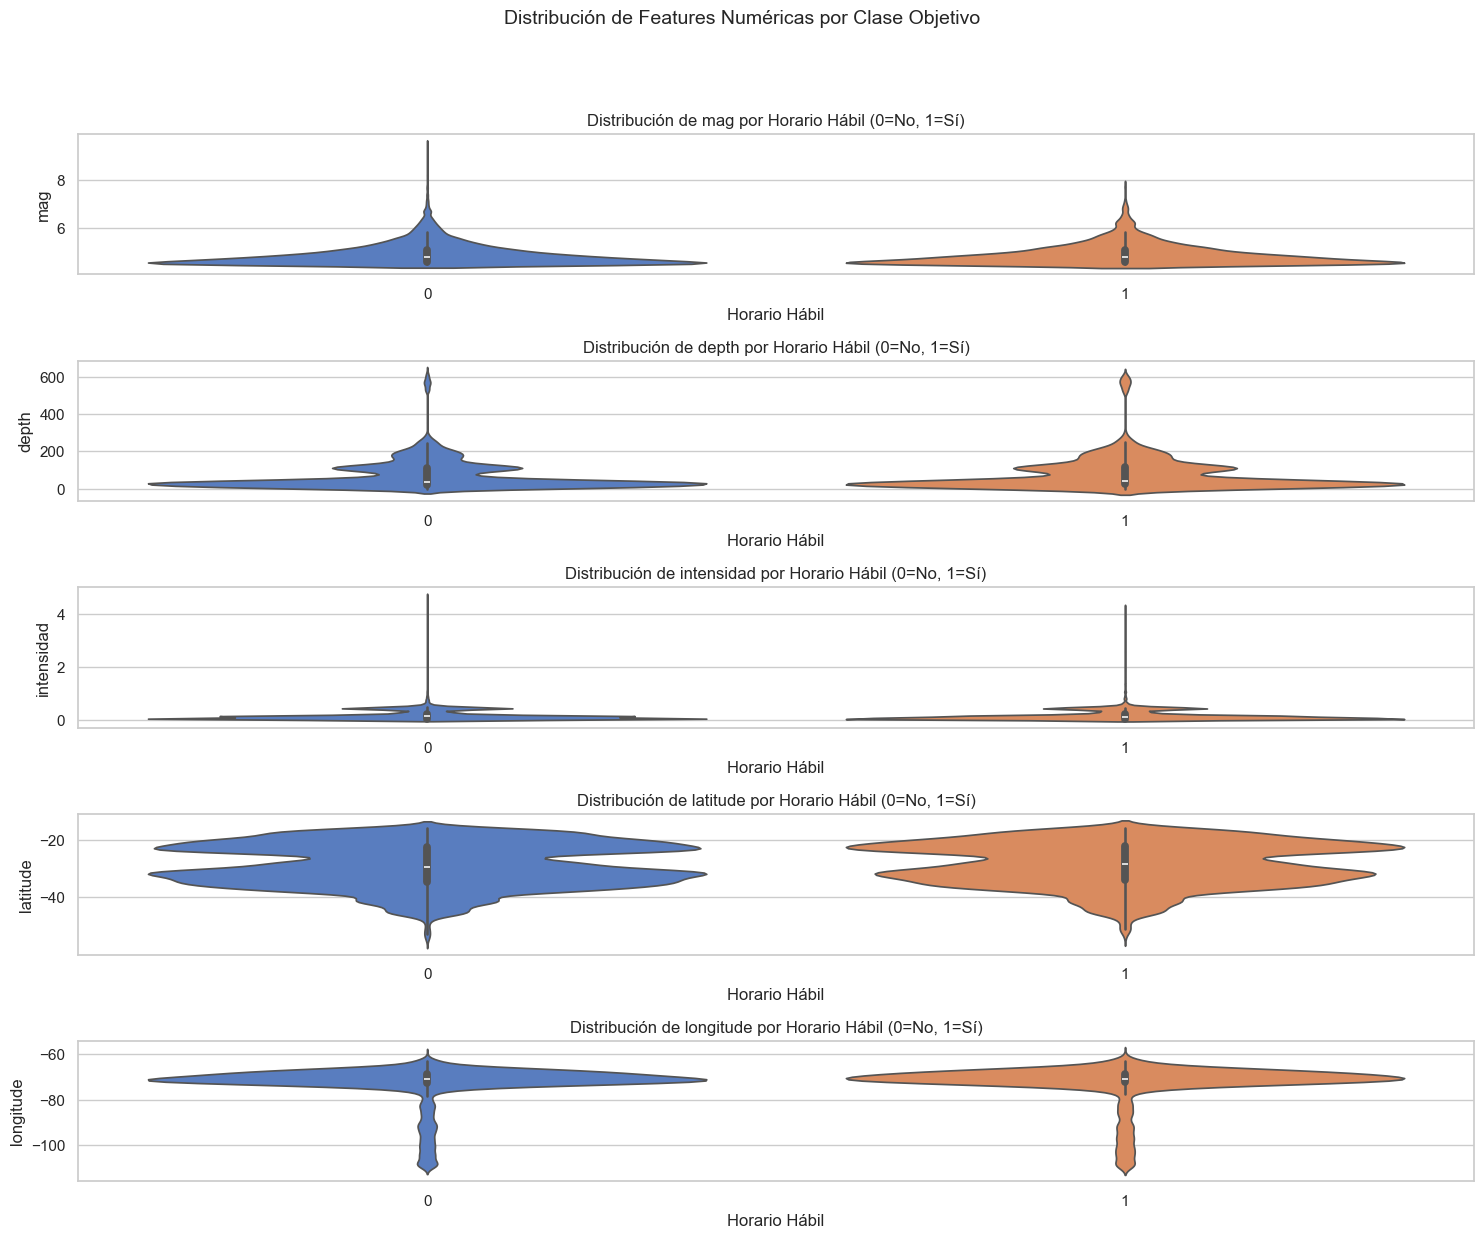


Analizando la distinción coloquial 'Temblor' vs 'Terremoto'...


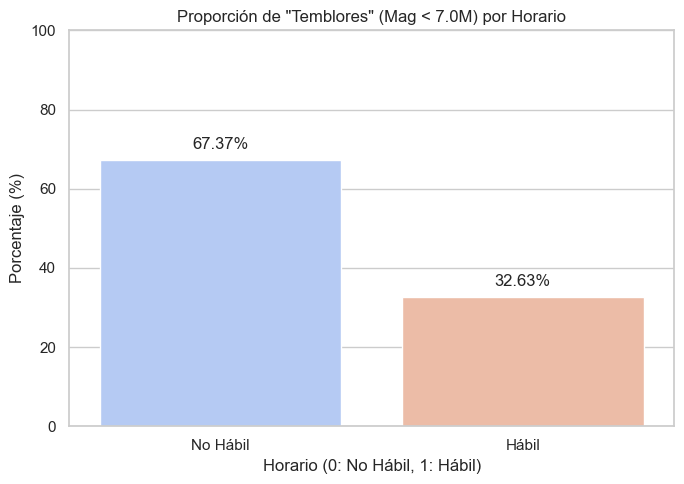

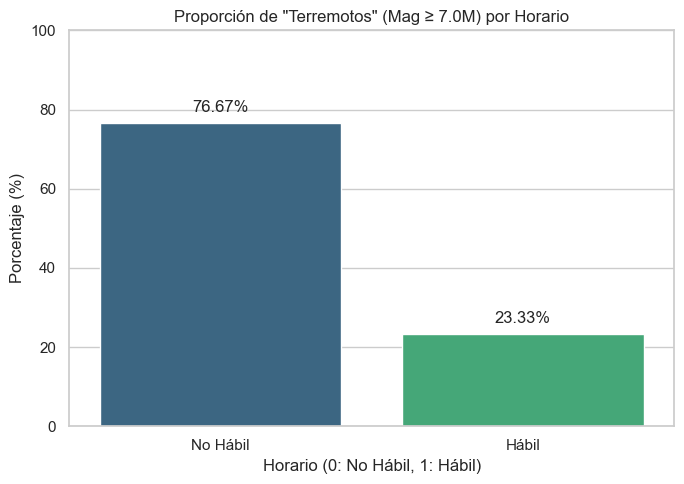

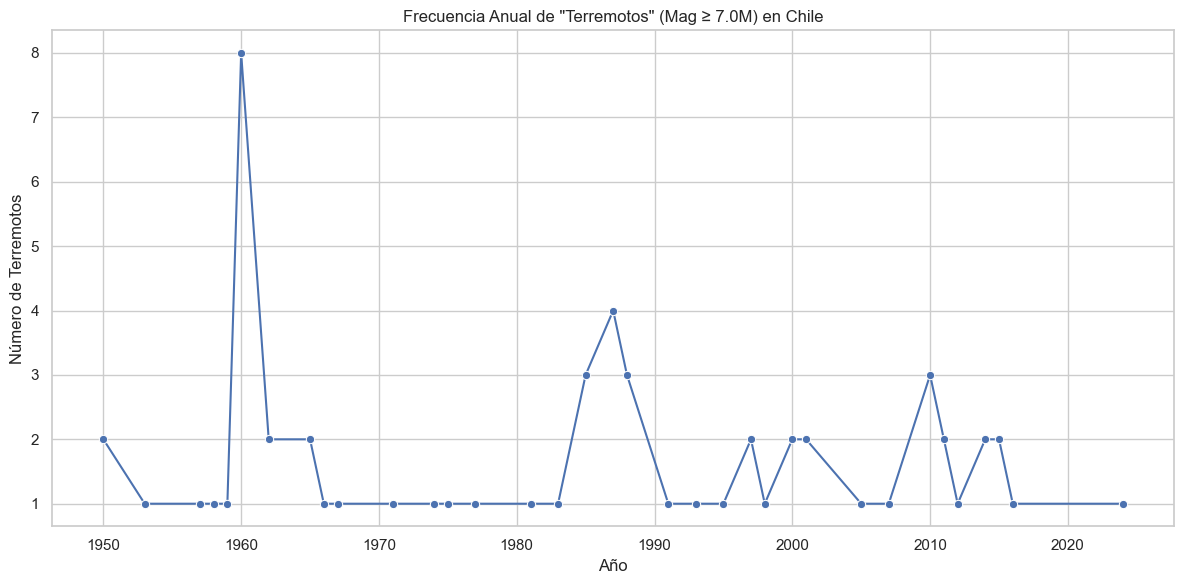

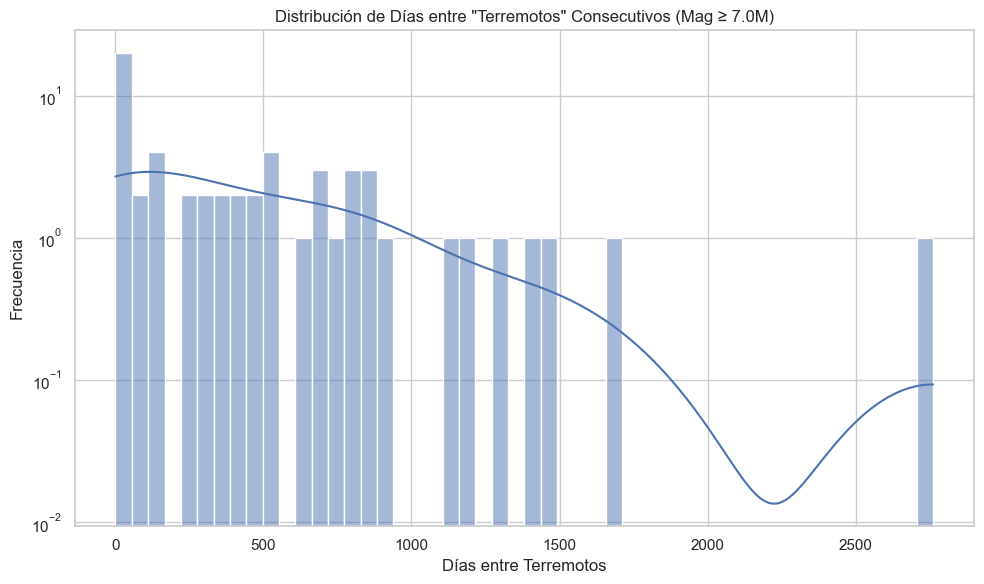


PASO 4: Dividiendo datos en entrenamiento y prueba...
Datos divididos: X_train=(11968, 8), X_test=(3990, 8), y_train=(11968,), y_test=(3990,)

PASO 5: Definiendo y aplicando preprocesamiento...
Aplicando RobustScaler a: ['mag', 'depth', 'latitude', 'longitude', 'intensidad', 'trimestre', 'mes']
Aplicando OneHotEncoder a: ['zona_riesgo']
Número de features después del preprocesamiento: 10
Dimensiones X_train procesado: (11968, 10)
Dimensiones X_test procesado: (3990, 10)

PASO 6: Aplicando resampling (Tomek Links por defecto)...
Usando resampler: TomekLinks

Balance de clases en y_train ANTES de resampling:
Horario_Habil_bin
0    0.674047
1    0.325953
Name: proportion, dtype: float64

Balance de clases en y_train DESPUÉS de resampling:
Horario_Habil_bin
0    0.631494
1    0.368506
Name: proportion, dtype: float64
Dimensiones X_train después de resampling: (10586, 10)

PASO 8: INICIANDO EVALUACIÓN DE MODELOS (CON FEATURES CORREGIDAS)
        (Resultados reflejarán la predictibilidad re

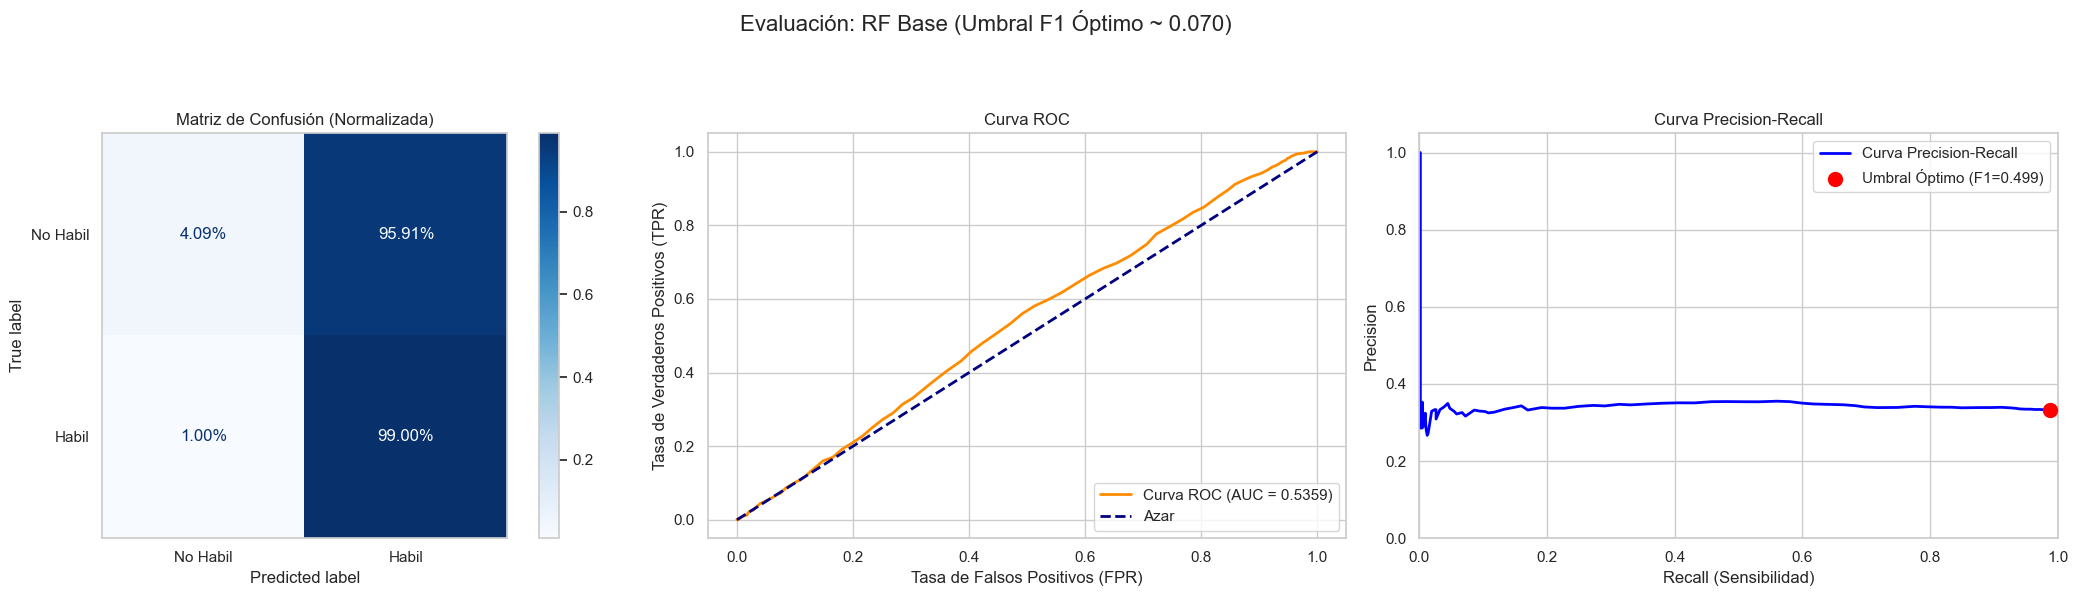


--- Evaluando: SFM(RF)+RF ---

===== Evaluación Detallada: SFM(RF)+RF =====
Umbral óptimo (max F1) encontrado: 0.0200 (F1 = 0.4924)

--- Reporte de Clasificación (Umbral Óptimo) ---
              precision    recall  f1-score   support

No Habil (0)       0.75      0.00      0.01      2689
   Habil (1)       0.33      1.00      0.49      1301

    accuracy                           0.33      3990
   macro avg       0.54      0.50      0.25      3990
weighted avg       0.61      0.33      0.17      3990

AUC-ROC: 0.5288


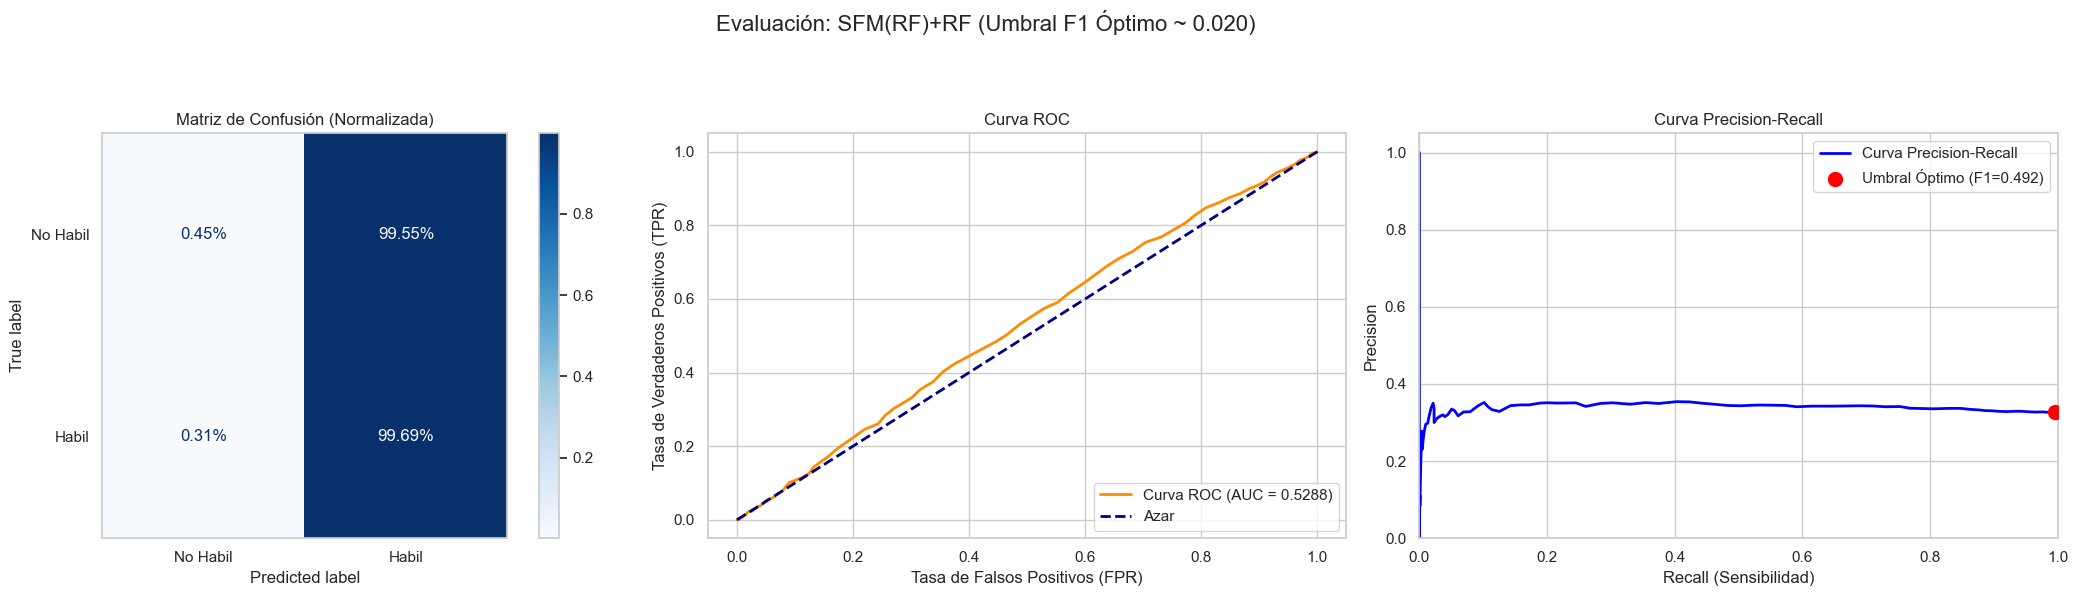

Features seleccionadas por SFM: 5 - ['num__mag', 'num__depth', 'num__latitude', 'num__longitude', 'num__intensidad']

--- Evaluando: RFECV(RF)+RF ---

===== Evaluación Detallada: RFECV(RF)+RF =====
Umbral óptimo (max F1) encontrado: 0.1100 (F1 = 0.4990)

--- Reporte de Clasificación (Umbral Óptimo) ---
              precision    recall  f1-score   support

No Habil (0)       0.86      0.06      0.10      2689
   Habil (1)       0.33      0.98      0.50      1301

    accuracy                           0.36      3990
   macro avg       0.59      0.52      0.30      3990
weighted avg       0.69      0.36      0.23      3990

AUC-ROC: 0.5401


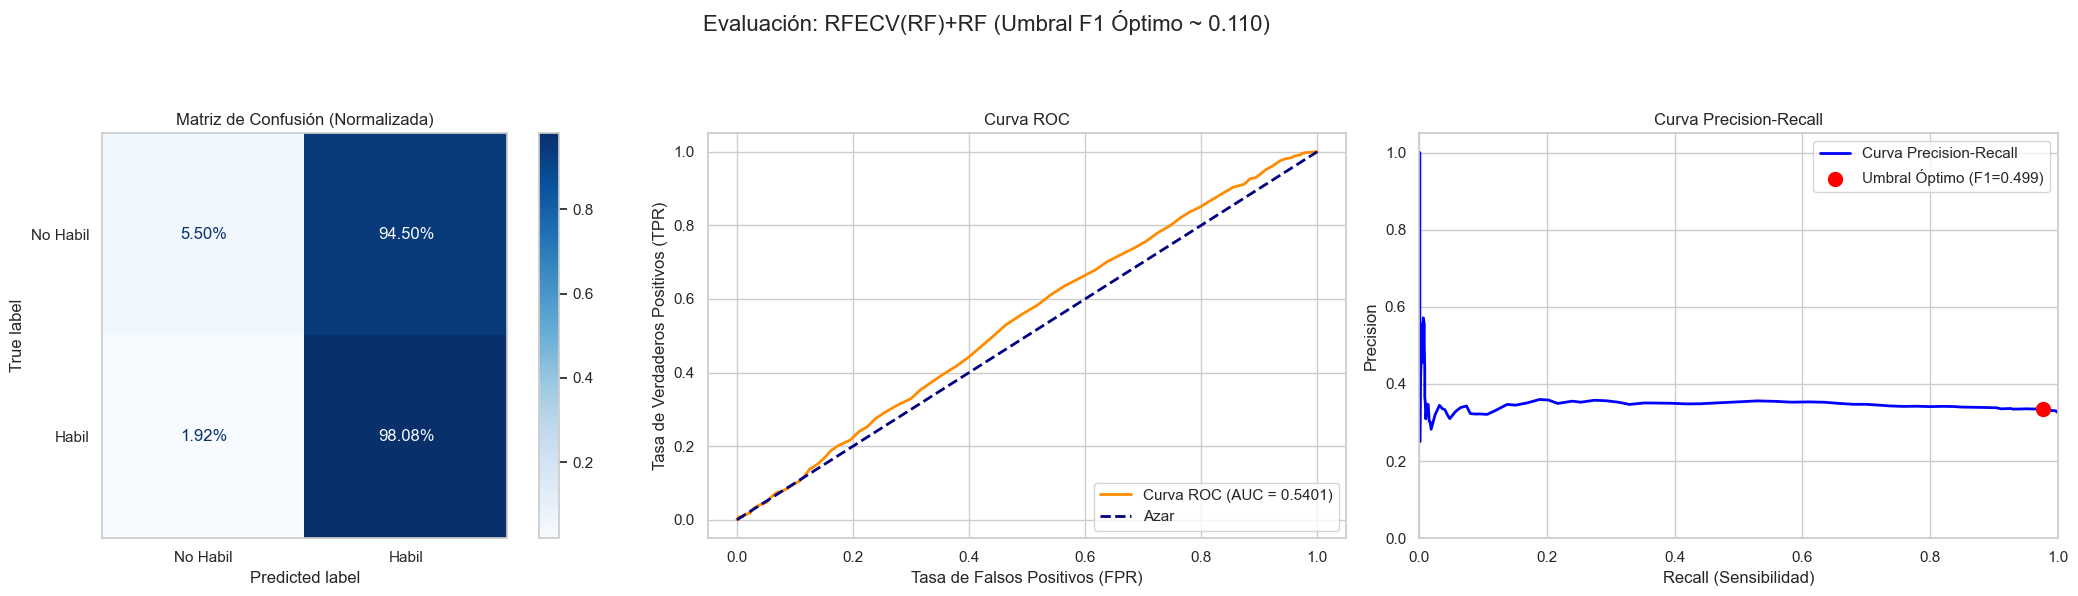


Features seleccionadas por RFECV: 9 - ['num__mag', 'num__depth', 'num__latitude', 'num__longitude', 'num__intensidad', 'num__trimestre', 'num__mes', 'cat__zona_riesgo_Austral', 'cat__zona_riesgo_Sur']

--- Evaluando: KBest(F-val, k=5)+RF ---

===== Evaluación Detallada: KBest(k=5)+RF =====
Umbral óptimo (max F1) encontrado: 0.0177 (F1 = 0.4949)

--- Reporte de Clasificación (Umbral Óptimo) ---
              precision    recall  f1-score   support

No Habil (0)       0.81      0.04      0.09      2689
   Habil (1)       0.33      0.98      0.49      1301

    accuracy                           0.35      3990
   macro avg       0.57      0.51      0.29      3990
weighted avg       0.65      0.35      0.22      3990

AUC-ROC: 0.5109


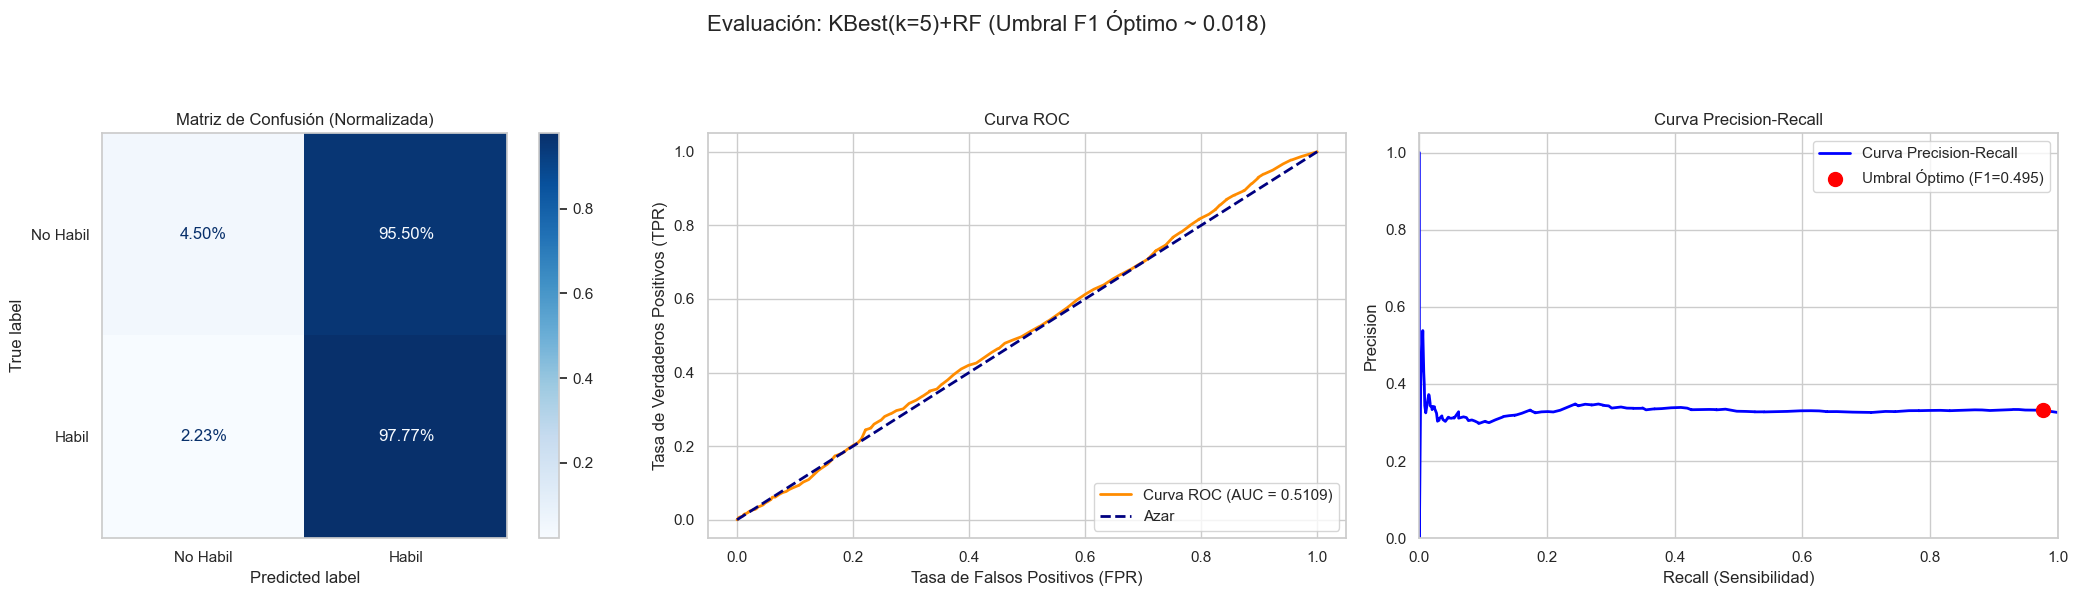


Features seleccionadas por SelectKBest: 5 - ['num__depth', 'num__latitude', 'cat__zona_riesgo_Austral', 'cat__zona_riesgo_Central', 'cat__zona_riesgo_Sur']


In [4]:
import pandas as pd
from datetime import datetime, time
import pytz
from workalendar.america import Chile # Para manejar días hábiles en Chile
import seaborn as sns
import numpy as np
import warnings

# --- Sklearn ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, f_classif
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay, roc_auc_score,
    precision_recall_curve, f1_score, roc_curve, auc, make_scorer
)
from sklearn.exceptions import NotFittedError # Importar NotFittedError

# --- Imbalanced-learn ---
try:
    from imblearn.under_sampling import TomekLinks
except ImportError:
    print("Instalando imbalanced-learn...")
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
        from imblearn.under_sampling import TomekLinks
    except Exception as e:
        print(f"Error instalando imbalanced-learn: {e}")
        sys.exit("Se requiere imbalanced-learn. Por favor, instálalo manualmente.")

# --- Joblib ---
from joblib import dump, load

# --- Configuraciones ---
# Suprimir warnings comunes para una salida más limpia 
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
# Configurar estilo de gráficos
sns.set_theme(style="whitegrid")

# ==============================================================================
# --- 1. Carga de Datos ---
# ==============================================================================
print("PASO 1: Cargando datos...")
url_df_github = "https://raw.githubusercontent.com/joaco2v/ProyectoDS-JoaquinVicuna/refs/heads/main/sismos_chile.csv"
try:
    df = pd.read_csv(url_df_github)
    print(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
except Exception as e:
    print(f"Error al cargar los datos desde GitHub: {e}")
    sys.exit("No se pudieron cargar los datos.")

# ==============================================================================
# --- 2. Preprocesamiento Inicial y Creación de Target / Features ---
# ==============================================================================
print("\nPASO 2: Preprocesamiento inicial, target y feature engineering...")
df["Fecha UTC"] = pd.to_datetime(df["time"], utc=True)
santiago_tz = pytz.timezone("America/Santiago")
df["Fecha UTC CL"] = df["Fecha UTC"].dt.tz_convert(santiago_tz)

# --- Definición Variable Objetivo (Target) ---
cal = Chile()
def es_habil(fecha_hora):
    fecha = fecha_hora.date()
    hora = fecha_hora.time()
    dia_semana = fecha_hora.weekday()
    if cal.is_holiday(fecha): return "No habil"
    if dia_semana >= 5: return "No habil" # Sábado (5) y Domingo (6)
    # Horario hábil: Lunes a Viernes, 7:30 a 19:30
    return "Habil" if time(7, 30) <= hora <= time(19, 30) else "No habil"

df["Horario_Habil"] = df["Fecha UTC CL"].apply(es_habil)
df['Horario_Habil_bin'] = df['Horario_Habil'].eq('Habil').astype(int) # Target binario

# --- Feature Engineering (Variables predictoras POTENCIALES) ---
# Se excluyen variables que definen directamente el target para evitar fuga de datos
df['trimestre'] = df["Fecha UTC CL"].dt.quarter
df['mes'] = df["Fecha UTC CL"].dt.month
df['intensidad'] = df['mag'] * (1/(df['depth'].clip(lower=0) + 1))
lat_bins = [-90, -30, -20, -10, 90]
lat_labels = ['Austral', 'Sur', 'Central', 'Norte']
df['zona_riesgo'] = pd.cut(df['latitude'], bins=lat_bins, labels=lat_labels, right=False)
df['zona_riesgo'] = df['zona_riesgo'].cat.add_categories('Desconocida').fillna('Desconocida')

# --- Lista Final de Features (Predictoras) SIN FUGA DE DATOS ---
features = [
    'mag', 'depth', 'latitude', 'longitude', 'intensidad',
    'zona_riesgo', 'trimestre', 'mes'
]
target = 'Horario_Habil_bin' # Usar la columna binaria creada

X = df[features].copy()
y = df[target].copy()

# Verificar NaNs en features seleccionadas
print("\nNaNs por columna en X (features finales):")
nan_check = X.isnull().sum()
print(nan_check)
if nan_check.sum() > 0:
    print("¡ADVERTENCIA! Se encontraron NaNs en las features. Se necesita imputación.")
    # Aquí iría la lógica de imputación si fuera necesaria
    # Para este ejemplo, asumiendo que no hay NaNs en las features finales como en el notebook original.

# ==============================================================================
# --- 3. Visualización Exploratoria (EDA) ---
# ==============================================================================
print("\nPASO 3: Visualización exploratoria (Distribución de features vs Target)...")

# Seleccionar algunas features numéricas clave para visualizar
features_to_plot_num = ['mag', 'depth', 'intensidad', 'latitude', 'longitude']
features_to_plot_num = [f for f in features_to_plot_num if f in X.columns]

if features_to_plot_num:
    plt.figure(figsize=(15, len(features_to_plot_num) * 2.5))
    for i, col in enumerate(features_to_plot_num):
        plt.subplot(len(features_to_plot_num), 1, i+1)
        sns.violinplot(x=y, y=X[col], palette="muted")
        plt.title(f'Distribución de {col} por Horario Hábil (0=No, 1=Sí)')
        plt.xlabel("Horario Hábil")
        plt.ylabel(col)
    plt.suptitle("Distribución de Features Numéricas por Clase Objetivo", y=1.02, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig('num_features_distribution.png')
    plt.show()
else:
    print("No se encontraron features numéricas clave para graficar.")

# Visualizar feature categórica (zona_riesgo)
# if 'zona_riesgo' in X.columns:
#     plt.figure(figsize=(10, 5))
#     zona_target_counts = df.groupby(['zona_riesgo', target]).size().unstack(fill_value=0)
#     zona_target_perc = zona_target_counts.apply(lambda x: x / x.sum() * 100, axis=1)
#     zona_target_perc.plot(kind='bar', stacked=True, colormap='coolwarm', ax=plt.gca())
#     plt.title('Distribución Porcentual Horario Hábil/No Hábil por Zona de Riesgo')
#     plt.ylabel('Porcentaje (%)')
#     plt.xlabel('Zona de Riesgo')
#     plt.xticks(rotation=45, ha='right')
#     plt.legend(title='Horario Hábil', labels=['No Habil (0)', 'Habil (1)'])
#     plt.tight_layout()
#     plt.savefig('zona_riesgo_distribution.png')
#     plt.show()
# else:
#     print("No se encontró la feature 'zona_riesgo' para graficar.")


# --- Nueva sección: Análisis de 'Temblor' vs 'Terremoto' (Coloquial) ---
print("\nAnalizando la distinción coloquial 'Temblor' vs 'Terremoto'...")

# Crear la columna 'tipo_sismo_coloquial'
# Asumimos que 'Terremoto' es mag >= 7M y 'Temblor' es mag < 7M
df['tipo_sismo_coloquial'] = np.where(df['mag'] >= 7.0, 'Terremoto', 'Temblor')

# --- Gráfico 1: Temblores en Horario Hábil y No Hábil ---
temblor_df = df[df['tipo_sismo_coloquial'] == 'Temblor'].copy()
temblor_counts = temblor_df['Horario_Habil_bin'].value_counts(normalize=True) * 100

plt.figure(figsize=(7, 5))
sns.barplot(x=temblor_counts.index, y=temblor_counts.values, palette='coolwarm')
plt.title('Proporción de "Temblores" (Mag < 7.0M) por Horario')
plt.xlabel('Horario (0: No Hábil, 1: Hábil)')
plt.ylabel('Porcentaje (%)')
plt.xticks(ticks=[0, 1], labels=['No Hábil', 'Hábil'])
plt.ylim(0, 100)
for index, value in enumerate(temblor_counts.values):
    plt.text(index, value + 2, f'{value:.2f}%', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('temblores_horario.png')
plt.show()

# --- Gráfico 2: Terremotos en Horario Hábil y No Hábil ---
terremoto_df = df[df['tipo_sismo_coloquial'] == 'Terremoto'].copy()
terremoto_counts = terremoto_df['Horario_Habil_bin'].value_counts(normalize=True) * 100

plt.figure(figsize=(7, 5))
sns.barplot(x=terremoto_counts.index, y=terremoto_counts.values, palette='viridis')
plt.title('Proporción de "Terremotos" (Mag ≥ 7.0M) por Horario')
plt.xlabel('Horario (0: No Hábil, 1: Hábil)')
plt.ylabel('Porcentaje (%)')
plt.xticks(ticks=[0, 1], labels=['No Hábil', 'Hábil'])
plt.ylim(0, 100)
for index, value in enumerate(terremoto_counts.values):
    plt.text(index, value + 2, f'{value:.2f}%', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('terremotos_horario.png')
plt.show()

# --- Gráfico 3: Periodicidad de Terremotos (Magnitud ≥ 7.0M) ---
# Filtrar solo por terremotos y ordenar por fecha
terremotos_fechas = df[df['mag'] >= 7.0].sort_values('Fecha UTC CL')['Fecha UTC CL']

# Extraer el año para un análisis de frecuencia anual
terremotos_anuales = terremotos_fechas.dt.year.value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=terremotos_anuales.index, y=terremotos_anuales.values, marker='o')
plt.title('Frecuencia Anual de "Terremotos" (Mag ≥ 7.0M) en Chile')
plt.xlabel('Año')
plt.ylabel('Número de Terremotos')
plt.grid(True)
plt.tight_layout()
plt.savefig('terremotos_anual.png')
plt.show()

# Opcional: Histograma de diferencias de tiempo entre terremotos (para ver si hay patrones de recurrencia en días/meses)
# Calcular la diferencia de tiempo entre eventos consecutivos
if len(terremotos_fechas) > 1:
    time_diffs = terremotos_fechas.diff().dropna().dt.days # Diferencia en días

    plt.figure(figsize=(10, 6))
    sns.histplot(time_diffs, bins=50, kde=True)
    plt.title('Distribución de Días entre "Terremotos" Consecutivos (Mag ≥ 7.0M)')
    plt.xlabel('Días entre Terremotos')
    plt.ylabel('Frecuencia')
    plt.yscale('log') # Escala logarítmica para ver colas largas
    plt.tight_layout()
    plt.savefig('terremotos_time_diff_hist.png')
    plt.show()
else:
    print("No hay suficientes 'Terremotos' para calcular diferencias de tiempo.")

# ==============================================================================
# --- 4. División de Datos (Entrenamiento y Prueba) ---
# ==============================================================================
print("\nPASO 4: Dividiendo datos en entrenamiento y prueba...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Datos divididos: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}")


# ==============================================================================
# --- 5. Preprocesamiento (Escalado y Codificación) ---
# ==============================================================================
print("\nPASO 5: Definiendo y aplicando preprocesamiento...")
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

if 'zona_riesgo' not in categorical_features and 'zona_riesgo' in X_train.columns:
    categorical_features.append('zona_riesgo')
    if 'zona_riesgo' in numeric_features: numeric_features.remove('zona_riesgo')


transformers_list = []
if numeric_features:
    transformers_list.append(('num', RobustScaler(), numeric_features))
    print(f"Aplicando RobustScaler a: {numeric_features}")
if categorical_features:
    transformers_list.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features))
    print(f"Aplicando OneHotEncoder a: {categorical_features}")

if not transformers_list:
     raise ValueError("No se definieron transformadores. Verifica las listas de features numéricas/categóricas.")

preprocessor = ColumnTransformer(transformers=transformers_list, remainder='drop')

# Ajustar y transformar
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Obtener nombres de features procesadas
try:
    feature_names_processed = preprocessor.get_feature_names_out()
    print(f"Número de features después del preprocesamiento: {len(feature_names_processed)}")
except Exception as e:
    print(f"No se pudieron obtener nombres de features procesadas: {e}")
    feature_names_processed = np.array([f"feat_{i}" for i in range(X_train_processed.shape[1])])

print(f"Dimensiones X_train procesado: {X_train_processed.shape}")
print(f"Dimensiones X_test procesado: {X_test_processed.shape}")


# ==============================================================================
# --- 6. Balanceo de Clases (Resampling) ---
# ==============================================================================
print("\nPASO 6: Aplicando resampling (Tomek Links por defecto)...")

resampler = TomekLinks(sampling_strategy='majority', n_jobs=-1)

print(f"Usando resampler: {type(resampler).__name__}")
print("\nBalance de clases en y_train ANTES de resampling:")
print(y_train.value_counts(normalize=True))

X_train_resampled_processed, y_train_resampled = resampler.fit_resample(X_train_processed, y_train)

print("\nBalance de clases en y_train DESPUÉS de resampling:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))
print(f"Dimensiones X_train después de resampling: {X_train_resampled_processed.shape}")


# ==============================================================================
# --- 7. Función de Evaluación Detallada ---
# ==============================================================================
def evaluate_model_detailed(pipeline, X_test_processed, y_test, model_name="Modelo"):
    """
    Evalúa un pipeline (selector + clasificador) o un clasificador ya entrenado,
    generando reporte, matriz de confusión, curva ROC y curva Precision-Recall.
    Retorna AUC y F1-score en el umbral óptimo.
    """
    print(f"\n===== Evaluación Detallada: {model_name} =====")
    try:
        y_probs = pipeline.predict_proba(X_test_processed)[:, 1]
    except NotFittedError as e:
        print(f"Error: El modelo/pipeline '{model_name}' no parece estar ajustado. {e}")
        return 0.0, 0.0
    except Exception as e:
        print(f"Error durante predict_proba para '{model_name}': {e}")
        return 0.0, 0.0

    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    f1_scores = np.nan_to_num(f1_scores)

    if len(f1_scores) > 0:
        idx_opt_f1 = np.argmax(f1_scores)
        if idx_opt_f1 > 0 and (idx_opt_f1 - 1) < len(pr_thresholds):
            optimal_threshold = pr_thresholds[idx_opt_f1 - 1]
        else:
            optimal_threshold = 0.5
        optimal_f1 = f1_scores[idx_opt_f1]
        print(f"Umbral óptimo (max F1) encontrado: {optimal_threshold:.4f} (F1 = {optimal_f1:.4f})")
    else:
        print("Advertencia: No se pudieron calcular F1 scores. Usando umbral 0.5.")
        optimal_threshold = 0.5
        optimal_f1 = 0

    y_pred_opt = (y_probs >= optimal_threshold).astype(int)

    report = classification_report(y_test, y_pred_opt, target_names=['No Habil (0)', 'Habil (1)'], zero_division=0)
    try:
        roc_auc = roc_auc_score(y_test, y_probs)
    except ValueError:
        print("Advertencia: ROC AUC no se puede calcular (posiblemente solo una clase presente en y_true o y_score).")
        roc_auc = 0.0
    print("\n--- Reporte de Clasificación (Umbral Óptimo) ---")
    print(report)
    print(f"AUC-ROC: {roc_auc:.4f}")

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    fig.suptitle(f'Evaluación: {model_name} (Umbral F1 Óptimo ~ {optimal_threshold:.3f})', fontsize=16, y=1.02)

    try:
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt, display_labels=['No Habil', 'Habil'], normalize='true', cmap='Blues', ax=axes[0], values_format=".2%")
        axes[0].set_title('Matriz de Confusión (Normalizada)'); axes[0].grid(False)
    except Exception as e: axes[0].set_title(f'Error CM:\n{e}')

    try:
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc_val = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc_val:.4f})')
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar')
        axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)'); axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
        axes[1].set_title('Curva ROC'); axes[1].legend(loc="lower right"); axes[1].grid(True)
    except Exception as e: axes[1].set_title(f'Error ROC:\n{e}')

    try:
        axes[2].plot(recall, precision, color='blue', lw=2, label='Curva Precision-Recall')
        if idx_opt_f1 < len(recall) and idx_opt_f1 < len(precision):
           axes[2].scatter(recall[idx_opt_f1], precision[idx_opt_f1], marker='o', color='red', s=100, zorder=5, label=f'Umbral Óptimo (F1={optimal_f1:.3f})')
        axes[2].set_xlabel('Recall (Sensibilidad)'); axes[2].set_ylabel('Precision')
        axes[2].set_ylim([0.0, 1.05]); axes[2].set_xlim([0.0, 1.0])
        axes[2].set_title('Curva Precision-Recall'); axes[2].legend(loc="best"); axes[2].grid(True)
    except Exception as e: axes[2].set_title(f'Error P-R:\n{e}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return roc_auc, optimal_f1

# ==============================================================================
# --- 8. Ejecución de Evaluaciones y Comparación ---
# ==============================================================================
print("\n" + "="*60)
print("PASO 8: INICIANDO EVALUACIÓN DE MODELOS (CON FEATURES CORREGIDAS)")
print("        (Resultados reflejarán la predictibilidad real, probablemente baja)")
print("="*60 + "\n")

results_summary = {}
num_processed_features = X_train_resampled_processed.shape[1]

# --- 1. Modelo Base (Random Forest) ---
print("\n--- Evaluando: RF Base ---")
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100, n_jobs=-1)
base_rf.fit(X_train_resampled_processed, y_train_resampled)
auc_base, f1_base = evaluate_model_detailed(base_rf, X_test_processed, y_test, model_name="RF Base")
results_summary["RF Base"] = {'AUC': auc_base, 'F1_Opt': f1_base, 'Num_Features': num_processed_features}

# --- 2. Selección con SelectFromModel (usando RF) ---
print("\n--- Evaluando: SFM(RF)+RF ---")
selector_estimator_sfm = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1)
pipeline_sfm_rf = Pipeline([
    ('feature_selection', SelectFromModel(selector_estimator_sfm, threshold='median')),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100, n_jobs=-1))
])
pipeline_sfm_rf.fit(X_train_resampled_processed, y_train_resampled)
auc_sfm, f1_sfm = evaluate_model_detailed(pipeline_sfm_rf, X_test_processed, y_test, model_name="SFM(RF)+RF")
try:
    selector_sfm_rf_fitted = pipeline_sfm_rf.named_steps['feature_selection']
    selected_features_sfm_mask = selector_sfm_rf_fitted.get_support()
    selected_features_sfm = feature_names_processed[selected_features_sfm_mask]
    num_sel_sfm = len(selected_features_sfm)
    print(f"Features seleccionadas por SFM: {num_sel_sfm} - {selected_features_sfm.tolist()}")
except IndexError:
     num_sel_sfm = selected_features_sfm_mask.sum()
     print(f"Features seleccionadas por SFM: {num_sel_sfm} (nombres no disponibles/inconsistentes)")
results_summary["SFM(RF)+RF"] = {'AUC': auc_sfm, 'F1_Opt': f1_sfm, 'Num_Features': num_sel_sfm}


# --- 3. Selección con RFECV ---
print("\n--- Evaluando: RFECV(RF)+RF ---")
f1_scorer_pos = make_scorer(f1_score, pos_label=1, zero_division=0)
estimator_rfe = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
pipeline_rfecv_rf = Pipeline([
    ('feature_selection', RFECV(
        estimator=estimator_rfe, scoring=f1_scorer_pos, cv=StratifiedKFold(3),
        step=1, n_jobs=-1, min_features_to_select=max(1, num_processed_features // 3)
        )),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100, n_jobs=-1))
])
pipeline_rfecv_rf.fit(X_train_resampled_processed, y_train_resampled)
auc_rfecv, f1_rfecv = evaluate_model_detailed(pipeline_rfecv_rf, X_test_processed, y_test, model_name="RFECV(RF)+RF")
try:
    selector_rfecv_fitted = pipeline_rfecv_rf.named_steps['feature_selection']
    selected_features_rfecv_mask = selector_rfecv_fitted.support_
    selected_features_rfecv = feature_names_processed[selected_features_rfecv_mask]
    num_sel_rfecv = selector_rfecv_fitted.n_features_
    print(f"\nFeatures seleccionadas por RFECV: {num_sel_rfecv} - {selected_features_rfecv.tolist()}")
except IndexError:
    num_sel_rfecv = selected_features_rfecv_mask.sum()
    print(f"\nFeatures seleccionadas por RFECV: {num_sel_rfecv} (nombres no disponibles/inconsistentes)")
results_summary["RFECV(RF)+RF"] = {'AUC': auc_rfecv, 'F1_Opt': f1_rfecv, 'Num_Features': num_sel_rfecv}


# --- 4. Selección con SelectKBest (ANOVA F-value) ---
k_best = min(5, num_processed_features)
print(f"\n--- Evaluando: KBest(F-val, k={k_best})+RF ---")
if k_best > 0:
    pipeline_kbest_rf = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif, k=k_best)),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100, n_jobs=-1))
    ])
    pipeline_kbest_rf.fit(X_train_resampled_processed, y_train_resampled)
    auc_kbest, f1_kbest = evaluate_model_detailed(pipeline_kbest_rf, X_test_processed, y_test, model_name=f"KBest(k={k_best})+RF")
    try:
        selector_kbest_fitted = pipeline_kbest_rf.named_steps['feature_selection']
        selected_features_kbest_mask = selector_kbest_fitted.get_support()
        selected_features_kbest = feature_names_processed[selected_features_kbest_mask]
        num_sel_kbest = len(selected_features_kbest)
        print(f"\nFeatures seleccionadas por SelectKBest: {num_sel_kbest} - {selected_features_kbest.tolist()}")
    except IndexError:
        num_sel_kbest = selected_features_kbest_mask.sum()
        print(f"\nFeatures seleccionadas por SelectKBest: {num_sel_kbest} (nombres no disponibles/inconsistentes)")
    results_summary[f"KBest(k={k_best})+RF"] = {'AUC': auc_kbest, 'F1_Opt': f1_kbest, 'Num_Features': num_sel_kbest}
else:
    print(f"Skipping SelectKBest porque k={k_best} no es válido.")


#### --- Justificación del Modelo Final (Resultados Realistas) ---
El modelo 'RFECV(RF)+RF' se selecciona como el 'mejor' relativo entre los evaluados.
Criterios de selección (ordenados por F1 desc, AUC desc, menos features):
  - F1-score (clase 'Habil', umbral óptimo): 0.4990
  - Área Bajo la Curva ROC (AUC):           0.5401
  - Número de features utilizadas:          9

Interpretación del Rendimiento:
El rendimiento general es BAJO (AUC cercano a 0.5, F1 bajo).
   Esto sugiere fuertemente que las features utilizadas (características físicas
   del sismo y temporalidad general) NO tienen una capacidad predictiva
   significativa para determinar si el sismo ocurre en horario hábil.

